In [ ]:
Traning Pre-Trained ResNet18

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import models
import warnings
warnings.filterwarnings("ignore")


def training_step(model, batch):
    images, labels = batch 
    out = model(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

def validation_step(model, batch):
    images, labels = batch 
    out = model(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}
    
def validation_epoch_end(model, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(model, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model,batch) for batch in val_loader]
    return validation_epoch_end(model,outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(model,batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(model,epoch, result)
        history.append(result)
        if epoch%2 == 0:
            path = f'/content/drive/MyDrive/transfer_learning/TL_epoch_{epoch}.pt'
            torch.save(model.state_dict(), path)
    return history
 
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig('/content/drive/MyDrive/transfer_learning/Accuracy_vs._No. of epochs.pdf',format='pdf')
    plt.show()


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.savefig('/content/drive/MyDrive/transfer_learning/Loss_vs._No. of epochs.pdf',format='pdf')
    plt.show()

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.savefig('/content/drive/MyDrive/transfer_learning/LearningRate_vs._No. of epochs.pdf',format='pdf')
    plt.show()












if __name__ == '__main__':
    # Data transforms (normalization & data augmentation)
    stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                            tt.RandomHorizontalFlip(), 
                            # tt.RandomRotate
                            # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                            # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                            tt.ToTensor(), 
                            tt.Normalize(*stats,inplace=True)])
    valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
    # PyTorch datasets
    train_ds = CIFAR10(root='data/', download=True, transform=train_tfms)
    valid_ds = CIFAR10(root='data/', train=False, transform=valid_tfms)
    dataset_size = len(train_ds)
    test_dataset_size = len(valid_ds)
    print(train_ds)
    print(valid_ds)
    batch_size = 400

    # PyTorch data loaders
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)
    device = get_default_device()
    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)

    model = to_device(models.resnet18(pretrained=True), device)
    print(model)
    os.environ['WANDB_CONSOLE'] = 'off'
    history = [evaluate(model, valid_dl)]
    print(history)

    epochs = 21
    max_lr = 0.01
    grad_clip = 0.1
    weight_decay = 1e-4
    opt_func = torch.optim.Adam

    os.environ['WANDB_CONSOLE'] = 'off'

    history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
    
    plot_accuracies(history)
    plot_losses(history)
    plot_lrs(history)

10%freezing


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[{'val_loss': 10.923805236816406, 'val_acc': 9.61538462433964e-05}]
Epoch [0], train_loss: 1.8824, val_loss: 0.9461, val_acc: 0.6657
Epoch [1], train_loss: 0.9271, val_loss: 0.8695, val_acc: 0.6991
Epoch [2], train_loss: 0.8442, val_loss: 0.7643, val_acc: 0.7376
Epoch [3], train_loss: 0.7920, val_loss: 0.7557, val_acc: 0.7373
Epoch [4], train_loss: 0.7785, val_loss: 0.7582, val_acc: 0.7373
Epoch [5], train_loss: 0.7504, val_loss: 0.7137, val_acc: 0.7565
Epoch [6], train_loss: 0.7091, val_loss: 0.7090, val_acc: 0.7548
Epoch [7], train_loss: 0.6870, val_loss: 0.6879, val_acc: 0.7604
Epoch [8], train_loss: 0.6520, val_loss: 0.6667, val_acc: 0.7686
Epoch [9], train_loss: 0.6347, val_loss: 0.6530, val_acc: 0.7735
Epoch [10], train_loss: 0.6207, val_loss: 0.6459, val_acc: 0.7719
Epoch [11], train_loss: 0.6065, val_loss: 0.6435, val_acc: 0.7784
Epoch [12], train_loss: 0.5768, val_loss: 0.6077, val_acc: 0.7867
Epoch [13], train_loss: 0.5557, val_loss: 0.6115, val_acc: 0.7901
Epoch [14], train_

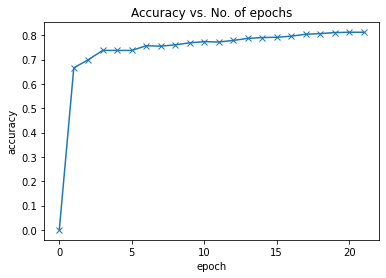

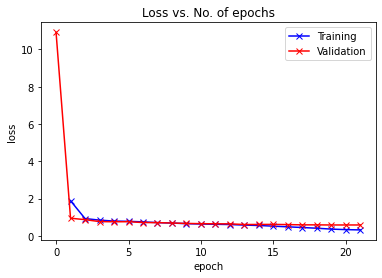

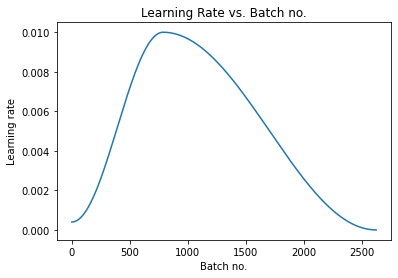

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import models
import warnings
warnings.filterwarnings("ignore")


def training_step(model, batch):
    images, labels = batch 
    out = model(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

def validation_step(model, batch):
    images, labels = batch 
    out = model(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}
    
def validation_epoch_end(model, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(model, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model,batch) for batch in val_loader]
    return validation_epoch_end(model,outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        test=0
        for batch in train_loader:
            loss = training_step(model,batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            # for i , param in enumerate(model.parameters()):

            #   if i==0 and test==0 :
            #     a=param
            #     print('param before step')
            #     print(param)

            optimizer.step()
            # for i , param in enumerate(model.parameters()):

            #   if i==0 and test==0:
            #     b=param
            #     print('param after step')
            #     print(param,a==b)
            test+=1
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(model,epoch, result)
        history.append(result)
        if epoch%2 == 0:
            path = f'/content/drive/MyDrive/transfer_learning/10_percent_freeze/TL_epoch_{epoch}.pt'
            torch.save(model.state_dict(), path)
    return history
 
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig('/content/drive/MyDrive/transfer_learning/10_percent_freeze/Accuracy_vs._No. of epochs.pdf',format='pdf')
    plt.show()


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.savefig('/content/drive/MyDrive/transfer_learning/10_percent_freeze/Loss_vs._No. of epochs.pdf',format='pdf')
    plt.show()

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.savefig('/content/drive/MyDrive/transfer_learning/10_percent_freeze/LearningRate_vs._No. of epochs.pdf',format='pdf')
    plt.show()









if __name__ == '__main__':
    # Data transforms (normalization & data augmentation)
    stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                            tt.RandomHorizontalFlip(), 
                            # tt.RandomRotate
                            # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                            # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                            tt.ToTensor(), 
                            tt.Normalize(*stats,inplace=True)])
    valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
    # PyTorch datasets
    train_ds = CIFAR10(root='data/', download=True, transform=train_tfms)
    valid_ds = CIFAR10(root='data/', train=False, transform=valid_tfms)
    dataset_size = len(train_ds)
    test_dataset_size = len(valid_ds)
    print(train_ds)
    print(valid_ds)
    batch_size = 400

    # PyTorch data loaders
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)
    device = get_default_device()
    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)

    model = to_device(models.resnet18(pretrained=True), device)
    # print(model)
    for i , param in enumerate(model.parameters()):
      if i>=0 and i<= 33:
        param.requires_grad = False #no of paramenters freezed=1568320
    os.environ['WANDB_CONSOLE'] = 'off'
    history = [evaluate(model, valid_dl)]
    print(history)

    epochs = 21
    max_lr = 0.01
    grad_clip = 0.1
    weight_decay = 1e-4
    opt_func = torch.optim.Adam

    os.environ['WANDB_CONSOLE'] = 'off'

    history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
    
    plot_accuracies(history)
    plot_losses(history)
    plot_lrs(history)

20% freezing

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
[{'val_loss': 10.923805236816406, 'val_acc': 9.61538462433964e-05}]
Epoch [0], train_loss: 1.9839, val_loss: 1.0606, val_acc: 0.6336
Epoch [1], train_loss: 1.0152, val_loss: 0.9344, val_acc: 0.6763
Epoch [2], train_loss: 0.9433, val_loss: 0.9452, val_acc: 0.6707
Epoch [3], train_loss: 0.9056, val_loss: 0.8887, val_acc: 0.6925
Epoch [4], train_loss: 0.876

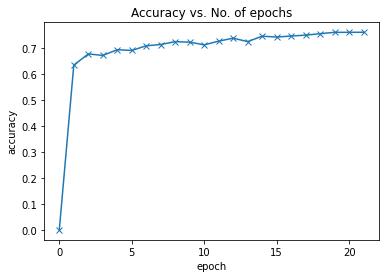

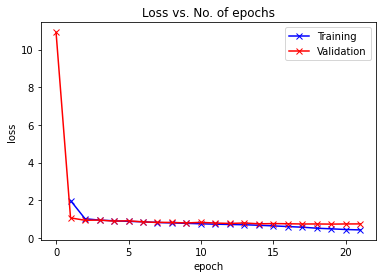

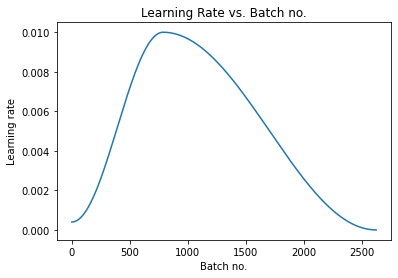

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import models
import warnings
warnings.filterwarnings("ignore")


def training_step(model, batch):
    images, labels = batch 
    out = model(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

def validation_step(model, batch):
    images, labels = batch 
    out = model(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}
    
def validation_epoch_end(model, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(model, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model,batch) for batch in val_loader]
    return validation_epoch_end(model,outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        test=0
        for batch in train_loader:
            loss = training_step(model,batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            # for i , param in enumerate(model.parameters()):

            #   if i==0 and test==0 :
            #     a=param
            #     print('param before step')
            #     print(param)

            optimizer.step()
            # for i , param in enumerate(model.parameters()):

            #   if i==0 and test==0:
            #     b=param
            #     print('param after step')
            #     print(param,a==b)
            test+=1
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(model,epoch, result)
        history.append(result)
        if epoch%2 == 0:
            path = f'/content/drive/MyDrive/transfer_learning/20_percent_freeze/TL_epoch_{epoch}.pt'
            torch.save(model.state_dict(), path)
    return history
 
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig('/content/drive/MyDrive/transfer_learning/20_percent_freeze/Accuracy_vs._No. of epochs.pdf',format='pdf')
    plt.show()


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.savefig('/content/drive/MyDrive/transfer_learning/20_percent_freeze/Loss_vs._No. of epochs.pdf',format='pdf')
    plt.show()

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.savefig('/content/drive/MyDrive/transfer_learning/20_percent_freeze/LearningRate_vs._No. of epochs.pdf',format='pdf')
    plt.show()









if __name__ == '__main__':
    # Data transforms (normalization & data augmentation)
    stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                            tt.RandomHorizontalFlip(), 
                            # tt.RandomRotate
                            # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                            # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                            tt.ToTensor(), 
                            tt.Normalize(*stats,inplace=True)])
    valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
    # PyTorch datasets
    train_ds = CIFAR10(root='data/', download=True, transform=train_tfms)
    valid_ds = CIFAR10(root='data/', train=False, transform=valid_tfms)
    dataset_size = len(train_ds)
    test_dataset_size = len(valid_ds)
    print(train_ds)
    print(valid_ds)
    batch_size = 400

    # PyTorch data loaders
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)
    device = get_default_device()
    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)

    model = to_device(models.resnet18(pretrained=True), device)
    # print(model)
    for i , param in enumerate(model.parameters()):
      if i>=0 and i<= 43:
        param.requires_grad = False #no of paramenters freezed=1568320
    os.environ['WANDB_CONSOLE'] = 'off'
    history = [evaluate(model, valid_dl)]
    print(history)

    epochs = 21
    max_lr = 0.01
    grad_clip = 0.1
    weight_decay = 1e-4
    opt_func = torch.optim.Adam

    os.environ['WANDB_CONSOLE'] = 'off'

    history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
    
    plot_accuracies(history)
    plot_losses(history)
    plot_lrs(history)

30% freezing


Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
[{'val_loss': 10.923805236816406, 'val_acc': 9.61538462433964e-05}]
Epoch [0], train_loss: 2.1099, val_loss: 1.1503, val_acc: 0.5977
Epoch [1], train_loss: 1.1119, val_loss: 1.0270, val_acc: 0.6389
Epoch [2], train_loss: 1.0461, val_loss: 1.0260, val_acc: 0.6422
Epoch [3], train_loss: 0.9978, val_loss: 0.9983, val_acc: 0.6582
Epoch [4], train_loss: 0.970

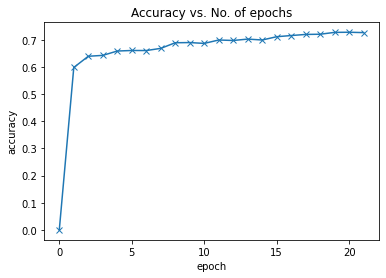

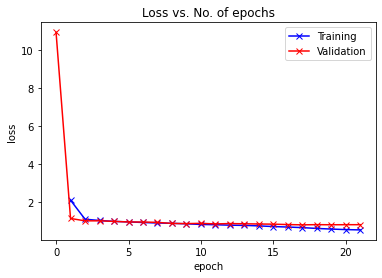

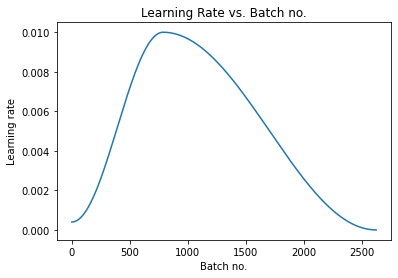

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import models
import warnings
warnings.filterwarnings("ignore")


def training_step(model, batch):
    images, labels = batch 
    out = model(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

def validation_step(model, batch):
    images, labels = batch 
    out = model(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}
    
def validation_epoch_end(model, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(model, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model,batch) for batch in val_loader]
    return validation_epoch_end(model,outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        test=0
        for batch in train_loader:
            loss = training_step(model,batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            # for i , param in enumerate(model.parameters()):

            #   if i==0 and test==0 :
            #     a=param
            #     print('param before step')
            #     print(param)

            optimizer.step()
            # for i , param in enumerate(model.parameters()):

            #   if i==0 and test==0:
            #     b=param
            #     print('param after step')
            #     print(param,a==b)
            test+=1
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(model,epoch, result)
        history.append(result)
        if epoch%2 == 0:
            path = f'/content/drive/MyDrive/transfer_learning/30_percent_freeze/TL_epoch_{epoch}.pt'
            torch.save(model.state_dict(), path)
    return history
 
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig('/content/drive/MyDrive/transfer_learning/30_percent_freeze/Accuracy_vs._No. of epochs.pdf',format='pdf')
    plt.show()


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.savefig('/content/drive/MyDrive/transfer_learning/30_percent_freeze/Loss_vs._No. of epochs.pdf',format='pdf')
    plt.show()

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.savefig('/content/drive/MyDrive/transfer_learning/30_percent_freeze/LearningRate_vs._No. of epochs.pdf',format='pdf')
    plt.show()









if __name__ == '__main__':
    # Data transforms (normalization & data augmentation)
    stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                            tt.RandomHorizontalFlip(), 
                            # tt.RandomRotate
                            # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                            # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                            tt.ToTensor(), 
                            tt.Normalize(*stats,inplace=True)])
    valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
    # PyTorch datasets
    train_ds = CIFAR10(root='data/', download=True, transform=train_tfms)
    valid_ds = CIFAR10(root='data/', train=False, transform=valid_tfms)
    dataset_size = len(train_ds)
    test_dataset_size = len(valid_ds)
    print(train_ds)
    print(valid_ds)
    batch_size = 400

    # PyTorch data loaders
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)
    device = get_default_device()
    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)

    model = to_device(models.resnet18(pretrained=True), device)
    # print(model)
    for i , param in enumerate(model.parameters()):
      if i>=0 and i<= 45:
        param.requires_grad = False #no of paramenters freezed=1568320
    os.environ['WANDB_CONSOLE'] = 'off'
    history = [evaluate(model, valid_dl)]
    print(history)

    epochs = 21
    max_lr = 0.01
    grad_clip = 0.1
    weight_decay = 1e-4
    opt_func = torch.optim.Adam

    os.environ['WANDB_CONSOLE'] = 'off'

    history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
    
    plot_accuracies(history)
    plot_losses(history)
    plot_lrs(history)